<!--BOOK_INFORMATION-->
<img align="left" style="width:80px;height:98px;padding-right:20px;" src="https://raw.githubusercontent.com/joe-papa/pytorch-book/main/files/pytorch-book-cover.jpg">

This notebook contains an excerpt from the [PyTorch Pocket Reference](http://pytorchbook.com) book by [Joe Papa](http://joepapa.ai); content is available [on GitHub](https://github.com/joe-papa/pytorch-book).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joe-papa/pytorch-book/blob/main/04_01_Transfer_Learning.ipynb)

# Chapter 4 - Neural Network Development Reference Designs
# Image Classification with Transfer Learning

## Data Processing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = \
  'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
with urlopen(zipurl) as zipresp:
 with ZipFile(BytesIO(zipresp.read())) as zfile:
   zfile.extractall('./data')

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406], 
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])


In [ ]:
train_dataset = datasets.ImageFolder(
          root='data/hymenoptera_data/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(
            root='data/hymenoptera_data/val',
            transform=val_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=4)

## Model Design

In [ ]:
model = models.resnet18(pretrained=True)

print(model.fc)
# out: 
# Linear(in_features=512, out_features=1000, bias=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
print(model.fc)
# out: 
# Linear(in_features=512, out_features=2, bias=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


## Training and Validation

In [ ]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if
  torch.cuda.is_available() else "cpu") # <1>

model = model.to(device)
criterion = nn.CrossEntropyLoss() # <2>
optimizer = optim.SGD(
                    model.parameters(), 
                    lr=0.001, 
                    momentum=0.9) # <3>
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1) # <4>

In [ ]:
num_epochs=25

for epoch in range(num_epochs):

  model.train() # <1>
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()/inputs.size(0)
    running_corrects += \
      torch.sum(preds == labels.data) \
        /inputs.size(0)

  exp_lr_scheduler.step() # <2>
  train_epoch_loss = \
    running_loss / len(train_loader)
  train_epoch_acc = \
    running_corrects / len(train_loader)

  model.eval() # <3>
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()/inputs.size(0)
      running_corrects += \
        torch.sum(preds == labels.data) \
            /inputs.size(0)

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = \
    running_corrects.double() / len(val_loader)
  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.0675 Acc: 0.8852 Val: Loss: 0.0538 Acc: 0.9295
Train: Loss: 0.0857 Acc: 0.8607 Val: Loss: 0.0504 Acc: 0.9295
Train: Loss: 0.0592 Acc: 0.8648 Val: Loss: 0.0507 Acc: 0.9295
Train: Loss: 0.0585 Acc: 0.9057 Val: Loss: 0.0514 Acc: 0.9295
Train: Loss: 0.0624 Acc: 0.8811 Val: Loss: 0.0666 Acc: 0.9295
Train: Loss: 0.0572 Acc: 0.9057 Val: Loss: 0.0488 Acc: 0.9295
Train: Loss: 0.0708 Acc: 0.9016 Val: Loss: 0.0500 Acc: 0.9295
Train: Loss: 0.0683 Acc: 0.8770 Val: Loss: 0.0596 Acc: 0.9295
Train: Loss: 0.0645 Acc: 0.8975 Val: Loss: 0.0514 Acc: 0.9295
Train: Loss: 0.0724 Acc: 0.8525 Val: Loss: 0.0493 Acc: 0.9295
Train: Loss: 0.0678 Acc: 0.8852 Val: Loss: 0.0508 Acc: 0.9295
Train: Loss: 0.0766 Acc: 0.8689 Val: Loss: 0.0510 Acc: 0.9231
Train: Loss: 0.0828 Acc: 0.8811 Val: Loss: 0.0473 Acc: 0.9231
Train: Loss: 0.0689 Acc: 0.9016 Val: Loss: 0.0502 Acc: 0.9103
Train: Loss: 0.0631 Acc: 0.8975 Val: Loss: 0.0488 Acc: 0.9295
Train: Loss: 0.0650 Acc: 0.8770 Val: Loss: 0.0499 Acc: 0.9295
Train: L

## Testing and Deployment

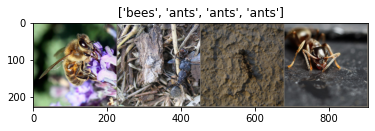

In [ ]:
import matplotlib.pyplot as plt

def imshow(inp, title=None): # <1>
    inp = inp.numpy().transpose((1, 2, 0)) # <2>
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # <3>
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader)) # <4>
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device)) # <5>
_, preds = torch.max(outputs,1) # <6>

imshow(out, title=[class_names[x] for x in preds]) # <7>

In [ ]:
torch.save(model.state_dict(), "./resnet18.pt")